In [1]:
import pandas as pd
import os
import time
import numpy as np
import seaborn as sns
import pickle
import torch
from pathlib import Path
from tqdm.notebook import tqdm
import argparse
import math
import matplotlib.pyplot as plt
import sys
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, auc
from scipy.stats import chi2_contingency, fisher_exact
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression,SGDClassifier
import joblib
from sklearn.model_selection import train_test_split


sys.path.insert(0, '..')

import dataset.preprocessing as utils
from config import *

In [2]:
emb_dir = os.path.join(processed_files_dir, 'nt_data', 'mean_embeddings')

In [3]:
columns_to_keep = ['gene1', 'gene2', 'x1', 'y1', 'w', 'h']
df_splash = pd.read_csv(os.path.join(processed_files_dir, 'splash.csv')).filter(columns_to_keep, axis = 1)
df_splash['dataset'] = 'splash'
df_genes_splash=pd.read_csv(os.path.join(processed_files_dir, 'df_genes_splash.csv'))[['gene_id', 'cdna', 'length', 'UTR5', 'CDS', 'UTR3']]

In [4]:
def create_df_coord(df_coord, drop_duplicates = True):
    #dataset with all the interactinons of the datasets
    df_coord['x2'] = df_coord['x1'] + df_coord['w'] 
    df_coord['y2'] = df_coord['y1'] + df_coord['h'] 

    df_coord1 = df_coord[['gene1', 'x1', 'x2', 'dataset']].rename({'gene1':'gene_id', 'x1':'start', 'x2':'end'}, axis=1)
    df_coord2 = df_coord[['gene2', 'y1', 'y2', 'dataset']].rename({'gene2':'gene_id', 'y1':'start', 'y2':'end'}, axis=1)
    if drop_duplicates:
        df_coord = pd.concat([df_coord1, df_coord2], axis = 0).drop_duplicates().reset_index(drop = True)
    else:
        df_coord = pd.concat([df_coord1, df_coord2], axis = 0).reset_index(drop = True)
    return df_coord

In [5]:
df_coord_splash = create_df_coord(
    df_splash, drop_duplicates = False
).merge(df_genes_splash[['gene_id', 'length', 'UTR5', 'CDS', 'UTR3']])

### Profile 

In [6]:
# Define a function to calculate density at each position
def calculate_density(start, end, weight, gene_length):
    density = np.zeros(gene_length)
    for i in range(len(start)):
        density[int(start[i]):int(end[i])] += weight[i]
    return density / np.max(density)  # Normalize density between 0 and 1

# Create a function to generate the profile
def generate_profile(df, gene_length):
    density = calculate_density(df['start'], df['end'], df['weight'], gene_length)
    return density

In [338]:
selected_gene = df_coord_splash.gene_id.value_counts().index[-10] #0, 23, -10, -23, -1, -2, -3


row = df_genes_splash[df_genes_splash.gene_id == selected_gene].iloc[0]
gene_length, cdna = row.length, row.cdna
UTR5, CDS, UTR3 = row.UTR5, row.CDS, row.UTR3
if np.isnan(UTR5):
    protein_coding = False
else:
    protein_coding = True

In [339]:
data = df_coord_splash[df_coord_splash.gene_id == selected_gene].reset_index(drop = True)
data['weight'] = 1

In [340]:
real_interaction_profile = generate_profile(data, gene_length)

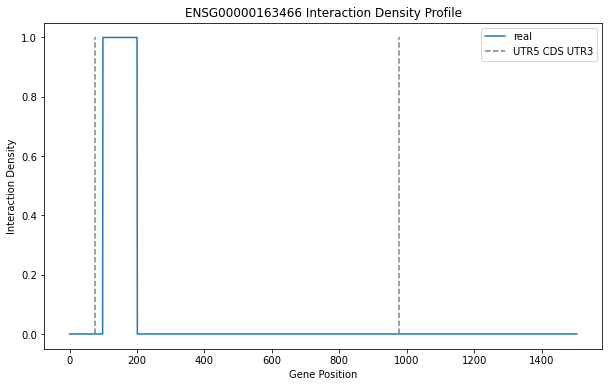

In [341]:
x_axis = np.arange(len(real_interaction_profile))
plt.figure(figsize=(10, 6))
plt.plot(x_axis, real_interaction_profile, label = 'real')
if protein_coding:
    plt.vlines(UTR5, ymin = 0, ymax = 1, color = 'grey', ls='--', lw=1.5, label = 'UTR5 CDS UTR3')
    plt.vlines(CDS, ymin = 0, ymax = 1, color = 'grey', ls='--', lw=1.5)
plt.xlabel('Gene Position')
plt.ylabel('Interaction Density')
plt.legend()
plt.title(f'{selected_gene} Interaction Density Profile')
plt.show()

In [342]:
start = 0
end = gene_length
windows_length = 29
overlap = 10
min_length = 20

def create_coordinates(start, end, distance, overlap, min_length):
    coordinates = [(start + i * (distance - overlap), start + (i + 1) * (distance - overlap) + overlap) for i in range((end - start) // (distance - overlap))]
    coordinates.append((coordinates[-1][1] - overlap, end))  # Adjusting the last tuple to reach the end
    coordinates = [(s, e) for (s, e) in coordinates if (s<e) & (e<=end) & (e-s >= min_length)]
    return coordinates

In [343]:
coordinates = create_coordinates(start, end, windows_length, overlap, min_length)

def create_df_query(id_gene, cdna, coordinates):
    diz = {}
    for _, (start, end) in enumerate(coordinates):
        diz[_] = {'id_query': id_gene + '_' + str(start) + '_' + str(end), 'cdna': cdna[start:end], 'start':start, 'end':end}
    return pd.DataFrame.from_dict(diz, orient = 'index')

In [344]:
predicted_profile = create_df_query(selected_gene, cdna, coordinates)

In [345]:
df_query = predicted_profile[['id_query', 'cdna']]

all_files = os.listdir(os.path.join(emb_dir, '32'))
all_files = list(pd.Series(all_files).str.extractall('(.*)\.npy').reset_index()[0])
df_query = df_query[~df_query.id_query.isin(all_files)]

df_query.to_csv(os.path.join(emb_dir, 'embedding_query.csv'))

print('# of embedding to download: ', len(df_query))

# of embedding to download:  0


### Download embeddings

nohup python download_embeddings.py --save_mean=1 --batch_size=15 --path_to_embedding_query_dir=/data01/giorgio/RNARNA-NT/dataset/processed_files/nt_data/mean_embeddings --embedding_dir=/data01/giorgio/RNARNA-NT/dataset/processed_files/nt_data/mean_embeddings &> download_embeddings.out &

In [346]:
def load_features(arrays_to_load):
    # Initialize an empty list to store the loaded arrays
    loaded_arrays = []

    # Loop through each file and load the numpy array
    for file_name in tqdm(arrays_to_load):
        # Load the numpy array from file
        array_data = np.load(os.path.join(emb_dir, '32', file_name + '.npy'))

        # Append the loaded array to the list
        loaded_arrays.append(array_data)

    # Stack the loaded arrays along the first axis to create a single array
    result_array = np.stack(loaded_arrays)

    # Verify the shape of the resulting array
    print("Shape of the resulting array:", result_array.shape)
    
    return result_array

### Predicted profile

In [357]:
filename_scaler = os.path.join(emb_dir, 'scaler.joblib')
filename = os.path.join(emb_dir, 'rf_model_easy.joblib') #rf_model_easy3

clf = joblib.load(filename)
scaler = joblib.load(filename_scaler)

In [358]:
test_x = load_features(list(predicted_profile.id_query))

  0%|          | 0/78 [00:00<?, ?it/s]

Shape of the resulting array: (78, 2560)


In [359]:
# Define a function to calculate density at each position
def calculate_density_pred(start, end, weight, gene_length):
    density = np.zeros(gene_length)
    for i in range(len(start)):
        density[int(start[i]):int(end[i])] += weight[i]
    return density  # Normalize density between 0 and 1

# Create a function to generate the profile
def generate_profile_pred(df, gene_length):
    density = calculate_density_pred(df['start'], df['end'], df['weight'], gene_length)
    return density

In [360]:
#need this for correction. come sarebbe se fossero tutti ones?
predicted_profile['weight'] = pd.Series(np.ones(test_x.shape[0]))
predicted_interaction_profile_ones = generate_profile_pred(predicted_profile, gene_length)

#this is the real profile, but the counts are fake
test_x_scaled = scaler.transform(test_x)
predicted_profile['weight'] = pd.Series(clf.predict_proba(test_x_scaled)[:, 1])
predicted_interaction_profile = generate_profile_pred(predicted_profile, gene_length)

#correction
corrected_predicted_interaciton_profile = predicted_interaction_profile / predicted_interaction_profile_ones

/tmp/ipykernel_974484/933486646.py:11: RuntimeWarning: invalid value encountered in true_divide
  corrected_predicted_interaciton_profile = predicted_interaction_profile / predicted_interaction_profile_ones


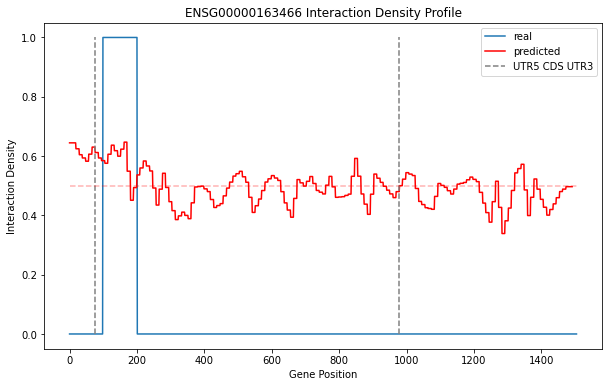

In [361]:
prediction_color = 'red'

x_axis = np.arange(len(real_interaction_profile))
plt.figure(figsize=(10, 6))
plt.plot(x_axis, real_interaction_profile, label = 'real')
plt.plot(x_axis, corrected_predicted_interaciton_profile, label = 'predicted', color = prediction_color)
if protein_coding:
    plt.vlines(UTR5, ymin = 0, ymax = 1, color = 'grey', ls='--', lw=1.5, label = 'UTR5 CDS UTR3')
    plt.vlines(CDS, ymin = 0, ymax = 1, color = 'grey', ls='--', lw=1.5)
plt.hlines(0.5, xmin = 0, xmax = len(real_interaction_profile), color = prediction_color, alpha=0.3, ls = '--')
plt.xlabel('Gene Position')
plt.ylabel('Interaction Density')
plt.legend()
plt.title(f'{selected_gene} Interaction Density Profile')
plt.show()